In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgbm

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,last_checkout_day_log,open_count_last_10_days_log,open_count_last_30_days_log,open_count_last_60_days_log,login_count_last_10_days_log,login_count_last_30_days_log,login_count_last_60_days_log,checkout_count_last_10_days_log,checkout_count_last_30_days_log,checkout_count_last_60_days_log
0,4,2019-07-16 00:00:00+08:00,43,44,19,6,18,0,2,4,...,2.944439,0.000000,1.098612,1.609438,2.564949,3.784190,4.605170,0.000000,1.791759,2.397895
1,4,2019-07-16 00:00:00+08:00,102,44,9,4,8,2,9,17,...,2.197225,1.098612,2.302585,2.890372,2.944439,3.891820,4.510860,0.693147,0.693147,1.609438
2,6,2019-07-16 00:00:00+08:00,177,49,14,5,5,0,4,12,...,1.791759,0.000000,1.609438,2.564949,3.218876,4.248495,4.787492,1.791759,2.995732,3.332205
3,1,2019-07-16 00:00:00+08:00,184,49,49,9,53,0,0,1,...,3.988984,0.000000,0.000000,0.693147,2.302585,3.178054,4.248495,0.693147,1.386294,1.945910
4,6,2019-07-16 00:00:00+08:00,221,49,227,6,221,0,0,0,...,5.402677,0.000000,0.000000,0.000000,1.098612,1.791759,1.791759,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71534,6,2019-09-02 00:00:00+08:00,127613,39,24,36,279,0,1,1,...,5.634790,0.000000,0.693147,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71535,2,2019-09-02 00:00:00+08:00,127620,38,46,10,51,0,0,1,...,3.951244,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71536,2,2019-09-02 00:00:00+08:00,127696,32,808,18141,1445,0,0,0,...,7.276556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
71537,2,2019-09-02 00:00:00+08:00,127807,38,5,34,1445,2,4,4,...,7.276556,1.098612,1.609438,1.609438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


open_flag
0    61083
1    10456
Name: country_code, dtype: int64


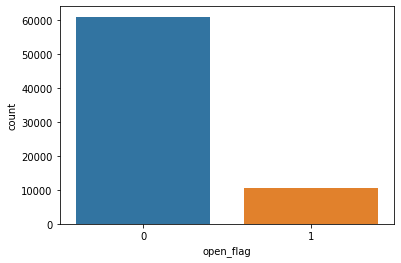

In [3]:
sns.countplot('open_flag', data=train)
print(train.groupby('open_flag').count()['country_code'])

open_flag
0    30500
1    20912
Name: country_code, dtype: int64


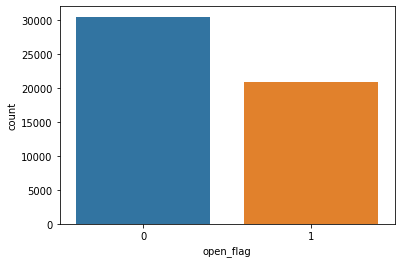

In [8]:
df0 = train[train['open_flag'] == 0]
df0 = df0.sample(30500, random_state=0)

df1 = train[train['open_flag'] == 1]
df1 = df1.append(df1, ignore_index=True)

train_resampled = pd.concat((df0, df1), ignore_index=True)

sns.countplot('open_flag', data=train_resampled)
print(train_resampled.groupby('open_flag').count()['country_code'])

In [9]:
def target_encoder(df, feature, label):
    ranking = df.groupby(feature).apply(lambda x: x[label].sum() / x[label].count())
    ranking = ranking.sort_values()

    encoder = {x: i for i, x in enumerate(ranking.index)}
    decoder = {i: x for i, x in enumerate(ranking.index)}
    return encoder, decoder

target_encoder(train_resampled, 'country_code', 'open_flag')

({1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6},
 {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4})

In [10]:
all_encoders = {}
all_decoders = {}

for x in ['country_code', 'domain', 'day_of_week']:
    encoder, decoder = target_encoder(train, x, 'open_flag')
    all_encoders[x] = encoder
    all_decoders[x] = decoder

    train_resampled[x + '_encoded'] = train_resampled[x].map(encoder)
    test[x + '_encoded'] = test[x].map(encoder)

print(all_encoders)
print(all_decoders)

{'country_code': {1: 0, 3: 1, 2: 2, 5: 3, 6: 4, 7: 5, 4: 6}, 'domain': {'@gmail.com': 0, '@163.com': 1, '@yahoo.com': 2, '@ymail.com': 3, '@rocketmail.com': 4, '@outlook.com': 5, '@qq.com': 6, '@live.com': 7, '@icloud.com': 8, '@hotmail.com': 9, 'other': 10}, 'day_of_week': {5: 0, 1: 1, 0: 2, 3: 3, 6: 4, 4: 5, 2: 6}}
{'country_code': {0: 1, 1: 3, 2: 2, 3: 5, 4: 6, 5: 7, 6: 4}, 'domain': {0: '@gmail.com', 1: '@163.com', 2: '@yahoo.com', 3: '@ymail.com', 4: '@rocketmail.com', 5: '@outlook.com', 6: '@qq.com', 7: '@live.com', 8: '@icloud.com', 9: '@hotmail.com', 10: 'other'}, 'day_of_week': {0: 5, 1: 1, 2: 0, 3: 3, 4: 6, 5: 4, 6: 2}}


In [11]:
encoded_features = [
    'subject_line_length',
    'last_open_day_log','last_login_day_log', 'last_checkout_day_log',
    'open_count_last_10_days_log', 'open_count_last_30_days_log', 'open_count_last_60_days_log', 
    'login_count_last_10_days_log', 'login_count_last_30_days_log', 'login_count_last_60_days_log',
    'checkout_count_last_10_days_log', 'checkout_count_last_30_days_log', 'checkout_count_last_60_days_log', 
    'attr_1', 'attr_2', 'attr_3',
    'country_code_encoded', 'domain_encoded', 'day_of_week_encoded'
]

In [13]:
for x in encoded_features:
    train_resampled[x] = train_resampled[x].astype(int)

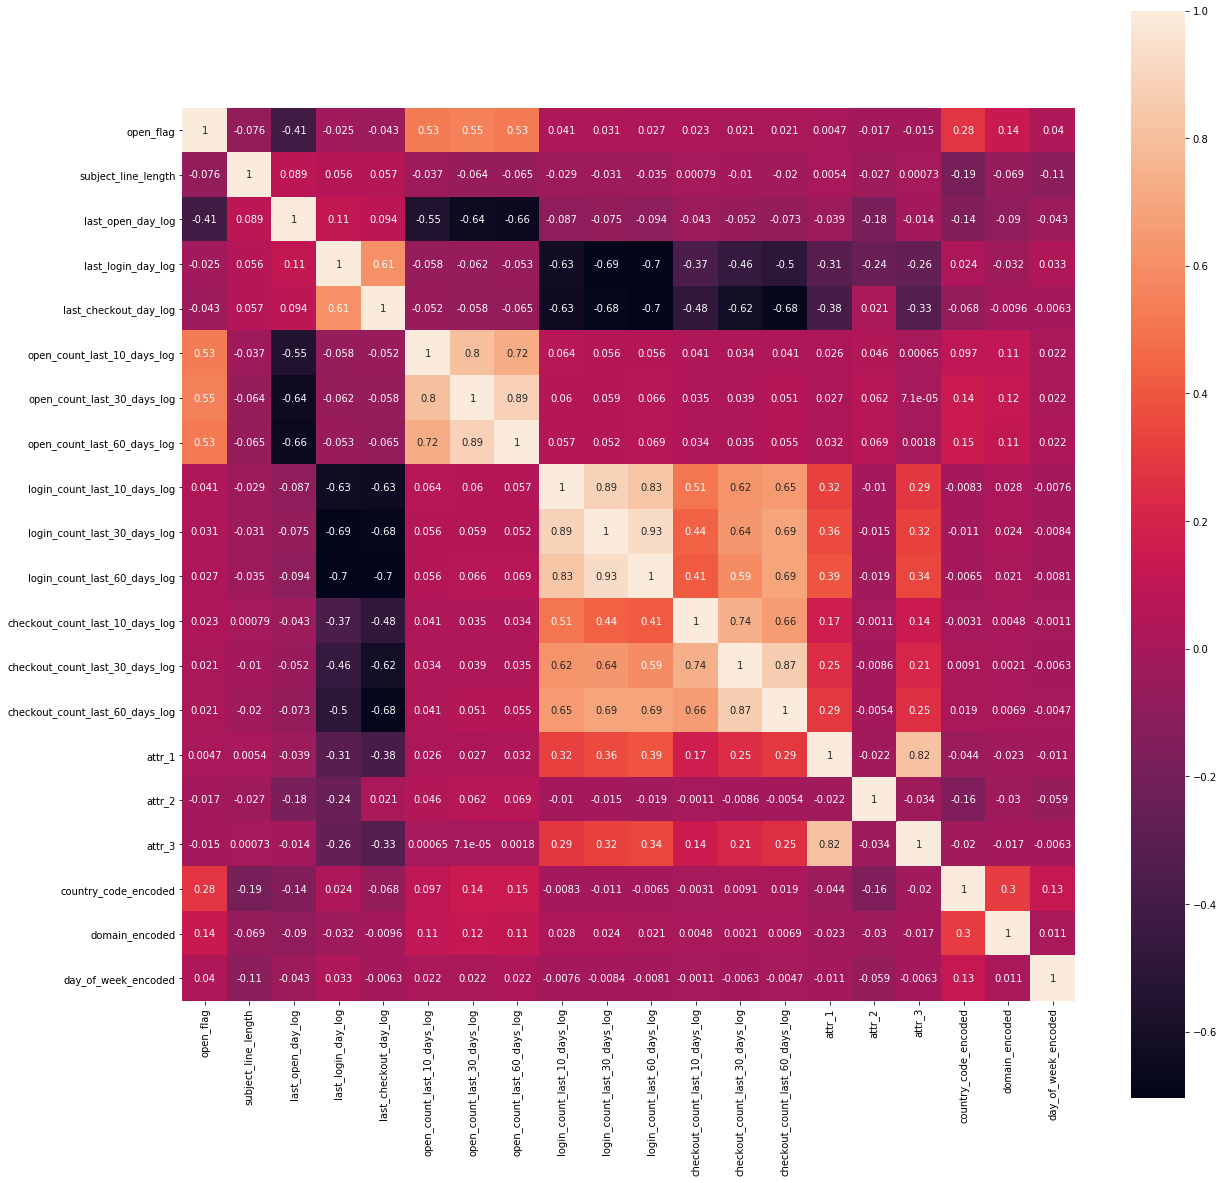

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(
    train_resampled.loc[:, ['open_flag'] + encoded_features].corr(), 
    square=True, annot=True
)

In [15]:
inputs = train_resampled.loc[:, encoded_features]
test_inputs = test.loc[:, encoded_features]

labels = train_resampled['open_flag']
test_labels = test['open_flag']

In [16]:
scale = StandardScaler()
inputs = scale.fit_transform(inputs)
test_inputs = scale.transform(test_inputs)

inputs

array([[-4.66816049e-01,  4.28889524e-01, -1.22301624e+00, ...,
         4.07598445e-02, -3.76647817e-01,  1.64533517e+00],
       [ 1.59072032e-01, -1.70606635e-01, -6.11995394e-01, ...,
         2.04223561e+00,  3.13115079e+00, -1.64603938e+00],
       [-1.98578300e-01,  4.28889524e-01, -6.11995394e-01, ...,
         1.04149773e+00,  2.35163999e+00, -3.52107679e-04],
       ...,
       [-4.66816049e-01, -7.70102793e-01,  6.10046289e-01, ...,
         4.07598445e-02,  1.96188459e+00, -5.48914532e-01],
       [ 5.16722364e-01,  4.28889524e-01,  2.44310881e+00, ...,
        -4.59609097e-01, -3.76647817e-01, -5.48914532e-01],
       [-4.66816049e-01, -7.70102793e-01,  6.10046289e-01, ...,
         4.07598445e-02, -3.76647817e-01, -5.48914532e-01]])

In [17]:
def test_model(model, inputs, labels, test_inputs, test_labels):
    print('Doing cross-validation...')
    cv_acc = cross_val_score(model, inputs, labels)
    print('CV accuracy: ', cv_acc, np.mean(cv_acc))

    print('Training model...')
    model.fit(inputs, labels)
    preds = model.predict(test_inputs)

    sns.heatmap(confusion_matrix(test_labels, preds), annot=True, fmt="d")
    print('Test accuracy: ', accuracy_score(test_labels, preds))
    print('Test Matthews: ', matthews_corrcoef(test_labels, preds))

    return model

In [18]:
forest = RandomForestClassifier(n_estimators=1000)
test_model(forest, inputs, labels, test_inputs, test_labels)

Doing cross-validation...


KeyboardInterrupt: 

In [50]:
kaggle_test = pd.read_csv('test_kaggle.csv')
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,row_id,attr_1,attr_2,attr_3,age,domain,day_of_week
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0,6,18,0,0.0,1.0,0.0,NaN,@gmail.com,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0,0,0,1,0.0,1.0,0.0,NaN,@gmail.com,1
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,2,2,2,2,1.0,1.0,2.0,33.0,@gmail.com,1
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,2,5,5,3,1.0,1.0,2.0,22.0,@yahoo.com,1
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0,0,2,4,0.0,1.0,0.0,NaN,@gmail.com,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,0,0,0,55965,0.0,1.0,0.0,NaN,@gmail.com,6
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,0,0,0,55966,0.0,1.0,0.0,NaN,@gmail.com,6
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,0,0,0,55967,0.0,1.0,0.0,NaN,@hotmail.com,6
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,0,0,0,55968,0.0,1.0,0.0,NaN,@gmail.com,6


In [51]:
for feature, encoder in all_encoders.items():
    kaggle_test[feature + '_encoded'] = kaggle_test[feature].map(encoder)

kaggle_inputs = kaggle_test.loc[:, encoded_features]
kaggle_inputs = scale.transform(kaggle_inputs)

In [52]:
kaggle_preds = forest.predict(kaggle_inputs)
kaggle_preds

array([1, 0, 0, ..., 0, 1, 1])

In [54]:
kaggle_test['open_flag'] = kaggle_preds
kaggle_test

,country_code,grass_date,user_id,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,...,attr_1,attr_2,attr_3,age,domain,day_of_week,country_code_encoded,domain_encoded,day_of_week_encoded,open_flag
0,6,2019-09-03 00:00:00+08:00,0,35,27,2,13,2,3,4,...,0.0,1.0,0.0,NaN,@gmail.com,1,4,0,1,1
1,6,2019-09-03 00:00:00+08:00,130,35,7,5,383,1,1,1,...,0.0,1.0,0.0,NaN,@gmail.com,1,4,0,1,0
2,5,2019-09-03 00:00:00+08:00,150,25,34,1,3,0,0,0,...,1.0,1.0,2.0,33.0,@gmail.com,1,3,0,1,0
3,1,2019-09-03 00:00:00+08:00,181,36,63,5,5,0,0,0,...,1.0,1.0,2.0,22.0,@yahoo.com,1,0,2,1,0
4,5,2019-09-03 00:00:00+08:00,192,23,6,5,54,0,0,0,...,0.0,1.0,0.0,NaN,@gmail.com,1,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,127348,53,808,4,8,0,0,0,...,0.0,1.0,0.0,NaN,@gmail.com,6,4,0,4,0
55966,6,2019-09-29 00:00:00+08:00,127396,53,59,802,1207,0,0,1,...,0.0,1.0,0.0,NaN,@gmail.com,6,4,0,4,0
55967,6,2019-09-29 00:00:00+08:00,127574,43,808,7,1445,0,0,0,...,0.0,1.0,0.0,NaN,@hotmail.com,6,4,9,4,0
55968,6,2019-09-29 00:00:00+08:00,127887,43,5,5,6,2,5,14,...,0.0,1.0,0.0,NaN,@gmail.com,6,4,0,4,1


In [55]:
kaggle_test.loc[:, ['row_id', 'open_flag']].to_csv('submission.csv', index=False)

In [56]:
from sklearn.svm import SVC

Doing cross-validation...
CV accuracy:  [0.80333333 0.80083333 0.77416667 0.79166667 0.78083333] 0.7901666666666666
Training model...
Test accuracy:  0.787
Test Matthews:  0.576552862331164


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

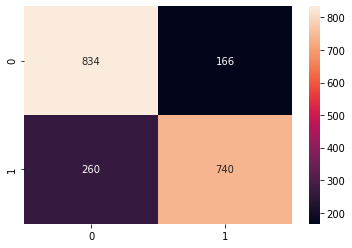

In [63]:
svm = SVC()
test_model(svm, inputs, labels, test_inputs, test_labels)

Doing cross-validation...
CV accuracy:  [0.79833333 0.7775     0.77333333 0.78333333 0.78083333] 0.7826666666666666
Training model...
Test accuracy:  0.7775
Test Matthews:  0.5550624480383041


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

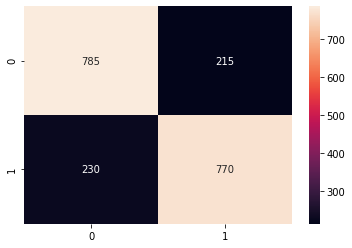

In [67]:
xgb_forest = xgb.XGBClassifier()
test_model(xgb_forest, inputs, labels, test_inputs, test_labels)